In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## DCGAN

In [2]:
num_eps = 10
bsize = 32
lrate = 0.001
noise_size = 64
img_size = 64
num_channels = 1

In [3]:
## DCGAN 생성기

class GANGenerator(nn.Module):
  def __init__(self):
    super().__init__()
    self.inp_sz = img_size // 4  # 4번 컨볼루션으로 줄어듬
    self.lin = nn.Linear(noise_size, 128*self.inp_sz**2)  # out: 128*4*4
    self.bn1 = nn.BatchNorm2d(128)
    self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
    self.cn1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(128, 0.8)
    self.rl1 = nn.LeakyReLU(0.2, inplace=True)
    self.up2 = nn.Upsample(scale_factor=2)
    self.cn2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64, 0.8)
    self.rl2 = nn.LeakyReLU(0.2, inplace=True)
    self.cn3 = nn.Conv2d(64, num_channels, kernel_size=3, stride=1, padding=1)
    self.act = nn.Tanh()

  def forward(self, x):
    x = self.lin(x)
    x = x.view(x.shape[0], 128, self.inp_sz, self.inp_sz)
    x = self.bn1(x)
    x = self.up1(x)
    x = self.cn1(x)
    x = self.bn2(x)
    x = self.rl1(x)
    x = self.up2(x)
    x = self.cn2(x)
    x = self.bn3(x)
    x = self.rl2(x)
    x = self.cn3(x)
    out = self.act(x)
    return x

In [4]:
## DCGAN Discriminator

class GANDiscriminator(nn.Module):
  def __init__(self):
    super().__init__()

    def disc_module(in_chnls, op_chnls, bnorm=True):
      mod = [
          nn.Conv2d(in_chnls, op_chnls, 3, 2, 1),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Dropout2d(0.25)
      ]
      if bnorm:
        mod += [nn.BatchNorm2d(op_chnls, 0.8)]
      return mod

    self.disc_model = nn.Sequential(
        *disc_module(num_channels, 16, bnorm=False),
        *disc_module(16, 32),
        *disc_module(32, 64),
        *disc_module(64, 128),
    )

    ds_size = img_size // 2**4
    self.adverse_lyr = nn.Sequential(
        nn.Linear(128*ds_size**2, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.disc_model(x)
    x = x.view(x.shape[0], -1)
    out = self.adverse_lyr(x)
    return out

In [5]:
gen = GANGenerator().to(device)
disc = GANDiscriminator().to(device)

adv_loss_func = nn.BCELoss()

In [6]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_data = datasets.MNIST(
    root='./',
    train=True,
    transform=transform,
    download=True
)

data_loader = DataLoader(
    train_data,
    batch_size=bsize,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 66.5kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]


In [9]:
opt_gen = optim.Adam(gen.parameters(), lr=lrate)
opt_disc = optim.Adam(disc.parameters(), lr=lrate)

In [8]:
from tqdm import tqdm

os.makedirs('./DCGAN_results', exist_ok=True)

In [12]:
for ep in tqdm(range(num_eps)):
  for idx, (images, _) in enumerate(data_loader):

    real_label = torch.ones((images.shape[0], 1), dtype=torch.float32).to(device)  # 1
    fake_label = torch.zeros((images.shape[0], 1), dtype=torch.float32).to(device) # 0

    real_images = images.to(device)

    ## generator
    noise = torch.randn(images.shape[0], noise_size).to(device)
    fake_images = gen(noise)

    opt_gen.zero_grad()
    generator_loss = adv_loss_func(disc(fake_images), real_label)
    generator_loss.backward()
    opt_gen.step()

    ## discriminator
    opt_disc.zero_grad()
    noise = torch.randn(images.shape[0], noise_size).to(device)
    fake_images = gen(noise)

    actual_image_loss = adv_loss_func(disc(real_images), real_label)
    fake_image_loss = adv_loss_func(disc(fake_images), fake_label)
    discriminator_loss = (actual_image_loss + fake_image_loss) / 2

    discriminator_loss.backward()
    opt_disc.step()

    if idx % 200 == 0:
        print(f"epoch {ep} | batch {idx} | generator loss = {generator_loss.item():.3f} | discriminator loss = {discriminator_loss.item():.3f}")
        save_image(fake_images.data[:25], f"DCGAN_results/{ep}.png", nrow=5, normalize=True)


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0 | batch 0 | generator loss = 2.365 | discriminator loss = 0.141
epoch 0 | batch 200 | generator loss = 4.122 | discriminator loss = 0.288
epoch 0 | batch 400 | generator loss = 1.178 | discriminator loss = 0.292
epoch 0 | batch 600 | generator loss = 1.440 | discriminator loss = 0.667
epoch 0 | batch 800 | generator loss = 2.098 | discriminator loss = 0.148
epoch 0 | batch 1000 | generator loss = 1.701 | discriminator loss = 0.219
epoch 0 | batch 1200 | generator loss = 1.287 | discriminator loss = 0.123
epoch 0 | batch 1400 | generator loss = 2.358 | discriminator loss = 0.097
epoch 0 | batch 1600 | generator loss = 1.737 | discriminator loss = 0.120
epoch 0 | batch 1800 | generator loss = 1.081 | discriminator loss = 0.504


 10%|█         | 1/10 [00:51<07:42, 51.44s/it]

epoch 1 | batch 0 | generator loss = 1.886 | discriminator loss = 0.064
epoch 1 | batch 200 | generator loss = 3.369 | discriminator loss = 0.065
epoch 1 | batch 400 | generator loss = 5.588 | discriminator loss = 0.388
epoch 1 | batch 600 | generator loss = 4.282 | discriminator loss = 0.203
epoch 1 | batch 800 | generator loss = 5.791 | discriminator loss = 0.080
epoch 1 | batch 1000 | generator loss = 1.848 | discriminator loss = 0.061
epoch 1 | batch 1200 | generator loss = 7.336 | discriminator loss = 0.158
epoch 1 | batch 1400 | generator loss = 3.838 | discriminator loss = 0.055
epoch 1 | batch 1600 | generator loss = 3.807 | discriminator loss = 0.156
epoch 1 | batch 1800 | generator loss = 5.826 | discriminator loss = 0.101


 20%|██        | 2/10 [01:42<06:51, 51.48s/it]

epoch 2 | batch 0 | generator loss = 1.805 | discriminator loss = 0.948
epoch 2 | batch 200 | generator loss = 6.809 | discriminator loss = 0.201
epoch 2 | batch 400 | generator loss = 5.914 | discriminator loss = 0.055
epoch 2 | batch 600 | generator loss = 3.296 | discriminator loss = 0.020
epoch 2 | batch 800 | generator loss = 5.616 | discriminator loss = 0.106
epoch 2 | batch 1000 | generator loss = 4.972 | discriminator loss = 0.211
epoch 2 | batch 1200 | generator loss = 6.866 | discriminator loss = 0.104
epoch 2 | batch 1400 | generator loss = 3.875 | discriminator loss = 0.119
epoch 2 | batch 1600 | generator loss = 3.433 | discriminator loss = 0.077
epoch 2 | batch 1800 | generator loss = 1.497 | discriminator loss = 0.472


 30%|███       | 3/10 [02:34<06:00, 51.46s/it]

epoch 3 | batch 0 | generator loss = 4.909 | discriminator loss = 0.095
epoch 3 | batch 200 | generator loss = 4.050 | discriminator loss = 0.162
epoch 3 | batch 400 | generator loss = 1.547 | discriminator loss = 0.293
epoch 3 | batch 600 | generator loss = 1.773 | discriminator loss = 0.094
epoch 3 | batch 800 | generator loss = 4.185 | discriminator loss = 0.050
epoch 3 | batch 1000 | generator loss = 5.867 | discriminator loss = 0.242
epoch 3 | batch 1200 | generator loss = 5.010 | discriminator loss = 0.195
epoch 3 | batch 1400 | generator loss = 4.721 | discriminator loss = 0.350
epoch 3 | batch 1600 | generator loss = 0.861 | discriminator loss = 0.394
epoch 3 | batch 1800 | generator loss = 2.605 | discriminator loss = 0.299


 40%|████      | 4/10 [03:25<05:08, 51.46s/it]

epoch 4 | batch 0 | generator loss = 4.579 | discriminator loss = 0.311
epoch 4 | batch 200 | generator loss = 3.032 | discriminator loss = 0.081
epoch 4 | batch 400 | generator loss = 2.052 | discriminator loss = 0.123
epoch 4 | batch 600 | generator loss = 5.806 | discriminator loss = 0.211
epoch 4 | batch 800 | generator loss = 4.558 | discriminator loss = 0.157
epoch 4 | batch 1000 | generator loss = 2.761 | discriminator loss = 0.153
epoch 4 | batch 1200 | generator loss = 9.254 | discriminator loss = 0.728
epoch 4 | batch 1400 | generator loss = 6.813 | discriminator loss = 0.043
epoch 4 | batch 1600 | generator loss = 3.763 | discriminator loss = 0.005
epoch 4 | batch 1800 | generator loss = 2.744 | discriminator loss = 0.090


 50%|█████     | 5/10 [04:17<04:17, 51.48s/it]

epoch 5 | batch 0 | generator loss = 3.864 | discriminator loss = 0.338
epoch 5 | batch 200 | generator loss = 7.987 | discriminator loss = 0.163
epoch 5 | batch 400 | generator loss = 5.206 | discriminator loss = 0.220
epoch 5 | batch 600 | generator loss = 5.667 | discriminator loss = 0.028
epoch 5 | batch 800 | generator loss = 1.552 | discriminator loss = 0.167
epoch 5 | batch 1000 | generator loss = 5.806 | discriminator loss = 0.335
epoch 5 | batch 1200 | generator loss = 6.496 | discriminator loss = 0.025
epoch 5 | batch 1400 | generator loss = 2.033 | discriminator loss = 0.386
epoch 5 | batch 1600 | generator loss = 6.653 | discriminator loss = 0.268
epoch 5 | batch 1800 | generator loss = 2.549 | discriminator loss = 0.830


 60%|██████    | 6/10 [05:08<03:26, 51.51s/it]

epoch 6 | batch 0 | generator loss = 8.001 | discriminator loss = 0.271
epoch 6 | batch 200 | generator loss = 7.817 | discriminator loss = 0.080
epoch 6 | batch 400 | generator loss = 4.068 | discriminator loss = 0.047
epoch 6 | batch 600 | generator loss = 3.673 | discriminator loss = 0.145
epoch 6 | batch 800 | generator loss = 6.117 | discriminator loss = 0.799
epoch 6 | batch 1000 | generator loss = 2.383 | discriminator loss = 0.083
epoch 6 | batch 1200 | generator loss = 8.605 | discriminator loss = 0.056
epoch 6 | batch 1400 | generator loss = 4.298 | discriminator loss = 0.205
epoch 6 | batch 1600 | generator loss = 6.127 | discriminator loss = 0.010
epoch 6 | batch 1800 | generator loss = 5.147 | discriminator loss = 0.046


 70%|███████   | 7/10 [06:00<02:34, 51.50s/it]

epoch 7 | batch 0 | generator loss = 7.368 | discriminator loss = 0.085
epoch 7 | batch 200 | generator loss = 3.946 | discriminator loss = 0.725
epoch 7 | batch 400 | generator loss = 1.809 | discriminator loss = 0.184
epoch 7 | batch 600 | generator loss = 2.775 | discriminator loss = 0.050
epoch 7 | batch 800 | generator loss = 2.189 | discriminator loss = 1.696
epoch 7 | batch 1000 | generator loss = 1.850 | discriminator loss = 0.110
epoch 7 | batch 1200 | generator loss = 10.592 | discriminator loss = 0.004
epoch 7 | batch 1400 | generator loss = 1.895 | discriminator loss = 0.129
epoch 7 | batch 1600 | generator loss = 5.149 | discriminator loss = 0.304
epoch 7 | batch 1800 | generator loss = 1.439 | discriminator loss = 0.049


 80%|████████  | 8/10 [06:51<01:42, 51.50s/it]

epoch 8 | batch 0 | generator loss = 5.302 | discriminator loss = 0.088
epoch 8 | batch 200 | generator loss = 7.939 | discriminator loss = 0.501
epoch 8 | batch 400 | generator loss = 6.961 | discriminator loss = 0.306
epoch 8 | batch 600 | generator loss = 3.465 | discriminator loss = 0.019
epoch 8 | batch 800 | generator loss = 6.582 | discriminator loss = 0.032
epoch 8 | batch 1000 | generator loss = 4.880 | discriminator loss = 0.071
epoch 8 | batch 1200 | generator loss = 3.836 | discriminator loss = 0.107
epoch 8 | batch 1400 | generator loss = 3.445 | discriminator loss = 0.099
epoch 8 | batch 1600 | generator loss = 3.558 | discriminator loss = 0.043
epoch 8 | batch 1800 | generator loss = 8.289 | discriminator loss = 0.020


 90%|█████████ | 9/10 [07:43<00:51, 51.50s/it]

epoch 9 | batch 0 | generator loss = 5.047 | discriminator loss = 0.040
epoch 9 | batch 200 | generator loss = 4.539 | discriminator loss = 0.105
epoch 9 | batch 400 | generator loss = 7.471 | discriminator loss = 0.038
epoch 9 | batch 600 | generator loss = 2.879 | discriminator loss = 0.281
epoch 9 | batch 800 | generator loss = 6.092 | discriminator loss = 0.007
epoch 9 | batch 1000 | generator loss = 8.958 | discriminator loss = 0.058
epoch 9 | batch 1200 | generator loss = 2.197 | discriminator loss = 0.131
epoch 9 | batch 1400 | generator loss = 3.428 | discriminator loss = 0.131
epoch 9 | batch 1600 | generator loss = 4.328 | discriminator loss = 0.001
epoch 9 | batch 1800 | generator loss = 3.675 | discriminator loss = 0.127


100%|██████████| 10/10 [08:34<00:00, 51.48s/it]


# XAI

In [6]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.cn1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
    self.cn2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
    self.dp1 = nn.Dropout2d(0.1)
    self.dp2 = nn.Dropout2d(0.2)
    self.fc1 = nn.Linear(4608, 64) # 12*12*32
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.cn1(x)
    x = F.relu(x)
    x = self.cn2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dp1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dp2(x)
    x = self.fc2(x)
    op = F.log_softmax(x, dim=1)
    return op

In [2]:
def train(model, device, train_dataloader, optim, epoch):
  model.train()
  for b_i, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    pred_prob = model(X)
    loss = F.nll_loss(pred_prob, y)

    optim.zero_grad()
    loss.backward()
    optim.step()

    if b_i % 100 == 0:
      print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader),
                loss.item()))

In [3]:
def test(model, device, test_dataloader):
  model.eval()
  loss = 0
  success = 0
  with torch.no_grad():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      pred_prob = model(X)
      loss = F.nll_loss(pred_prob, y).item()
      pred = pred_prob.argmax(dim=1)
      success += (pred == y).float().mean()

  loss /= len(test_dataloader)
  success /= len(test_dataloader)

  print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {:.3f}%'.format(
      loss, 100. * success))

In [4]:
path = os.path.join(os.getcwd(), 'data')

train_dataloader = DataLoader(
    datasets.MNIST(path, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))
                   ])),
                    batch_size=32, shuffle=True
)

test_dataloader = DataLoader(
    datasets.MNIST(path, train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))
                   ])),
                    batch_size=500, shuffle=True
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.68MB/s]


In [7]:
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.5)

In [8]:
for epoch in range(1, 10):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.273917
epoch: 1 [3200/60000 (5%)]	 training loss: 2.406723
epoch: 1 [6400/60000 (11%)]	 training loss: 2.392297
epoch: 1 [9600/60000 (16%)]	 training loss: 2.376077
epoch: 1 [12800/60000 (21%)]	 training loss: 2.340188
epoch: 1 [16000/60000 (27%)]	 training loss: 2.347467
epoch: 1 [19200/60000 (32%)]	 training loss: 2.399609
epoch: 1 [22400/60000 (37%)]	 training loss: 2.230605
epoch: 1 [25600/60000 (43%)]	 training loss: 2.387979
epoch: 1 [28800/60000 (48%)]	 training loss: 2.352157
epoch: 1 [32000/60000 (53%)]	 training loss: 2.281510
epoch: 1 [35200/60000 (59%)]	 training loss: 2.295725
epoch: 1 [38400/60000 (64%)]	 training loss: 2.372508
epoch: 1 [41600/60000 (69%)]	 training loss: 2.501194
epoch: 1 [44800/60000 (75%)]	 training loss: 2.448176
epoch: 1 [48000/60000 (80%)]	 training loss: 2.354408
epoch: 1 [51200/60000 (85%)]	 training loss: 2.405296
epoch: 1 [54400/60000 (91%)]	 training loss: 2.322549
epoch: 1 [57600/60000 (96%)]	 trainin

5


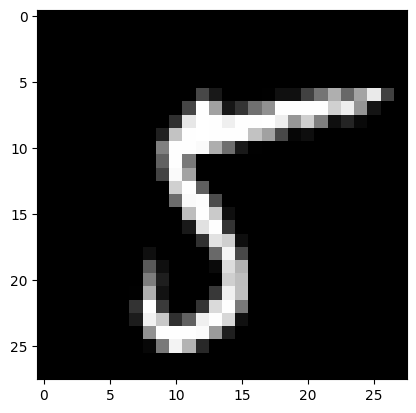

In [17]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

idx = np.random.randint(0, len(sample_targets))
print(sample_targets[idx].item())
plt.imshow(sample_data[idx][0], cmap='gray', interpolation='none')
plt.show()

## Visualize filter/kernel

In [20]:
dict(model.named_parameters()).keys()

dict_keys(['cn1.weight', 'cn1.bias', 'cn2.weight', 'cn2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [63]:
model_children_list = list(model.children())
convolution_layers = []
model_parameters = []
print('model_children_list[0] :', model_children_list[0])
print('model_children_list[2] :', model_children_list[2])
print(type(model_children_list[0]) == nn.Conv2d)

model_children_list[0] : Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
model_children_list[2] : Dropout2d(p=0.1, inplace=False)
True


In [64]:
for i in range(len(model_children_list)):
  if type(model_children_list[i]) == nn.Conv2d:
    model_parameters.append(model_children_list[i].weight)
    convolution_layers.append(model_children_list[i])

In [132]:
convolution_layers

[Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))]

In [65]:
print(len(model_parameters))
print(model_parameters[0].shape)
print(model_parameters[1].shape)

2
torch.Size([16, 1, 3, 3])
torch.Size([32, 16, 3, 3])


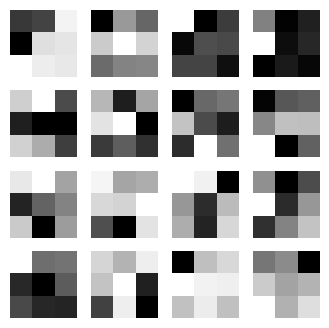

In [78]:
plt.figure(figsize=(4, 4))
for i, flt in enumerate(model_parameters[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(flt[0].cpu().detach().numpy(), cmap='gray')
  plt.axis('off')
plt.show()

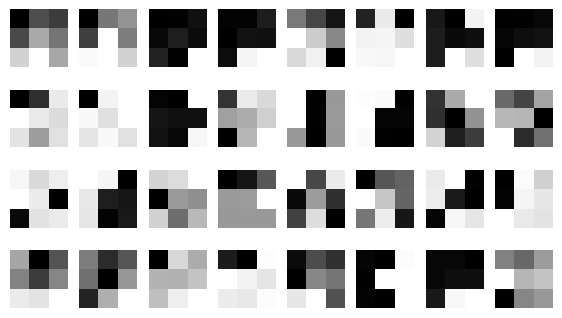

In [77]:
plt.figure(figsize=(7, 4))
for i, flt in enumerate(model_parameters[1]):
  plt.subplot(4, 8, i+1)
  plt.imshow(flt[0].cpu().detach().numpy(), cmap='gray')
  plt.axis('off')
plt.show()

## Visualize feature maps

In [86]:
sample_data.shape #MNIST
sample_data = sample_data.to(device)

[Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))]

torch.Size([500, 16, 26, 26])


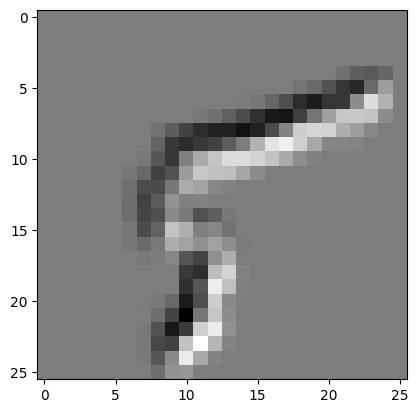

In [113]:
display(convolution_layers)

per_layer_results = convolution_layers[0](sample_data)
print(per_layer_results.shape)

plt.imshow(per_layer_results[-1].data.cpu().numpy()[0], cmap='gray_r')
plt.show()

In [127]:
per_layer_results[-1].shape

torch.Size([500, 16, 26, 26])

In [128]:
per_layer_results = [convolution_layers[0](sample_data)]

for i in range(1, len(convolution_layers)):
  per_layer_results.append(convolution_layers[i](per_layer_results[-1]))

In [133]:
print(len(per_layer_results))
print("per_layer_result[0] = ")
print(per_layer_results[0].shape)
print(per_layer_results[1].shape)

2
per_layer_result[0] = 
torch.Size([500, 16, 26, 26])
torch.Size([500, 32, 24, 24])


In [155]:
per_layer_results[1].shape

torch.Size([500, 32, 24, 24])

In [144]:
per_layer_results[0][0].data.shape

torch.Size([16, 26, 26])

torch.Size([16, 26, 26])


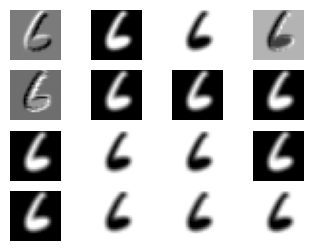

In [160]:
##
idx = np.random.randint(0, per_layer_results[0].shape[0])

plt.figure(figsize=(4, 3))
layer_visualisation = per_layer_results[0][idx].data

print(layer_visualisation.size())

for i, flt in enumerate(layer_visualisation):
  plt.subplot(4, 4, i+1)
  plt.imshow(flt.cpu().detach(), cmap='gray')
  plt.axis('off')
plt.show()

torch.Size([32, 24, 24])


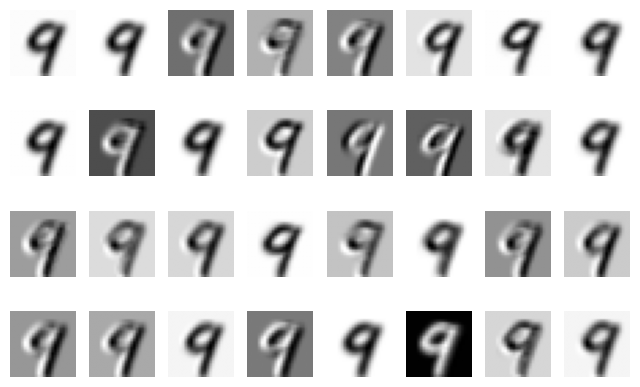

In [167]:
##
idx = np.random.randint(0, per_layer_results[1].shape[0])

plt.figure(figsize=(8, 5))
layer_visualisation = per_layer_results[1][idx].data

print(layer_visualisation.size())

for i, flt in enumerate(layer_visualisation):
  plt.subplot(4, 8, i+1)
  plt.imshow(flt.cpu().detach(), cmap='gray')
  plt.axis('off')
plt.show()

# XAI

In [168]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [277]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import visualization as viz

In [278]:
b_i, (sample_data, sample_target) = next(enumerate(test_dataloader))

print(sample_data.shape)
print(sample_target.shape)

torch.Size([500, 1, 28, 28])
torch.Size([500])


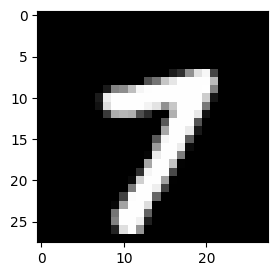

In [279]:
plt.figure(figsize=(3, 3))
plt.imshow(sample_data[0][0], cmap='gray')
plt.show()

In [280]:
sample_data = sample_data.to(device)

In [281]:
pred = model(sample_data)
prediction = pred.argmax(-1)[0].item()

print(prediction)
print(sample_target[0].item())

8
7


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [282]:
print(sample_data.shape)
print(sample_data[0].unsqueeze(0).shape)

torch.Size([500, 1, 28, 28])
torch.Size([1, 1, 28, 28])


In [283]:
captum_input = sample_data[0].unsqueeze(0)
captum_input.requires_grad = True

print(captum_input.shape)

torch.Size([1, 1, 28, 28])


torch.Size([1, 28, 28])


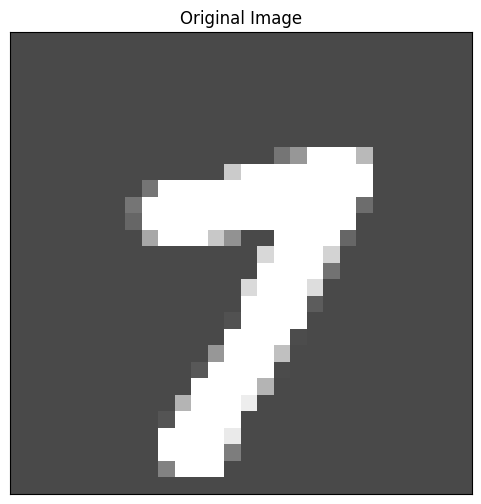

In [284]:
print(sample_data[0].shape)
# orig_image = np.tile((sample_data[0].cpu().detach().numpy().transpose(1, 2, 0) / 2) + 0.5, (1, 1, 3))
orig_image = np.tile(np.transpose((sample_data[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0)), (1,1,3))

orig_image.shape

_ = viz.visualize_image_attr(orig_image, orig_image, cmap='gray',
                         method='original_image', title='Original Image')

In [287]:
sample_target[0].item()

7

In [288]:
captum_input.shape

torch.Size([1, 1, 28, 28])

In [276]:
print(gradients.shape)
print(gradients.squeeze().shape)
print(gradients.squeeze().cpu().shape)
print(gradients.squeeze().cpu().detach().shape)
print(np.reshape(gradients.squeeze().cpu().detach().numpy(), (28, 28, 1)).shape)

(28, 28, 1)
(28, 28)


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

torch.Size([1, 1, 28, 28])
(28, 28, 1)


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


AssertionError: Cannot normalize by scale factor = 0

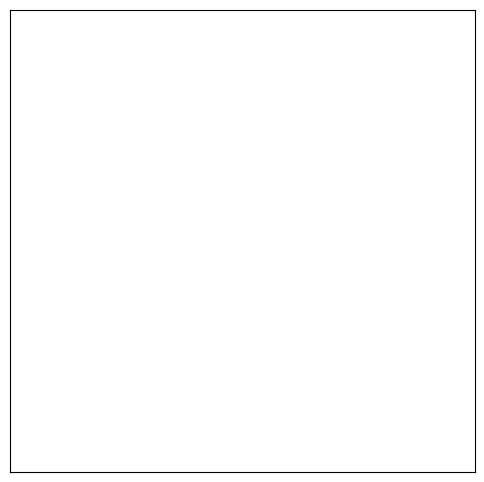

In [289]:
saliency = Saliency(model)
gradients = saliency.attribute(captum_input, target=sample_target[0].item())
print(gradients.shape)
gradients = np.reshape(gradients.squeeze().cpu().detach().numpy(), (28, 28, 1))
print(gradients.shape)
_ = viz.visualize_image_attr(gradients, orig_image, method='blended_heat_map',
                                       sign='absolute_value',
                                       show_colorbar=True,
                                       title = "Overlayed Gradients")

In [291]:
gradients.shape

(28, 28, 1)

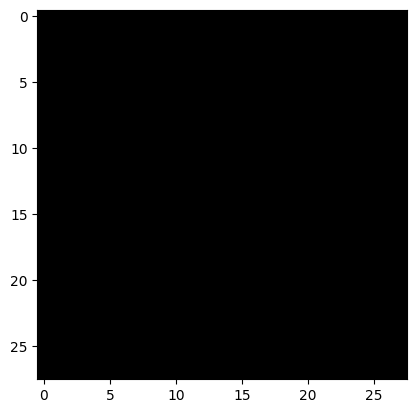

In [293]:
plt.imshow(gradients, cmap='gray')
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


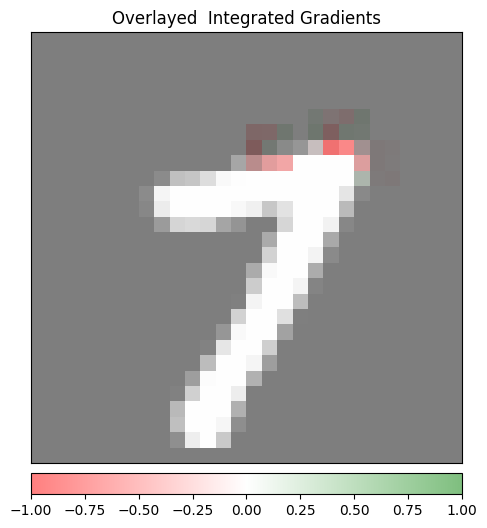

In [294]:
integ_grads = IntegratedGradients(model)
attributed_ig, delta = integ_grads.attribute(captum_input,
                                             target=sample_targets[0].item(),
                                             baselines=captum_input * 0,
                                             return_convergence_delta=True)

attributed_ig = np.reshape(attributed_ig.squeeze().cpu().detach().numpy(), (28, 28, 1))

_ = viz.visualize_image_attr(attributed_ig, orig_image, method='blended_heat_map',
                                       sign='all',
                                       show_colorbar=True,
                                       title = "Overlayed  Integrated Gradients")

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


AssertionError: Cannot normalize by scale factor = 0

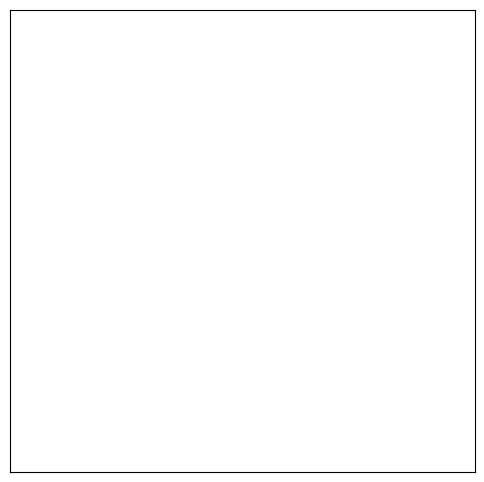

In [297]:
deep_lift = DeepLift(model)

attributed_dl = deep_lift.attribute(captum_input,
                                    target=sample_targets[0].item(),
                                    baselines=captum_input * 0,
                                    return_convergence_delta=False)

attributed_dl = np.reshape(attributed_dl.squeeze(0).cpu().detach().numpy(), (28, 28, 1))
_ = viz.visualize_image_attr(attributed_dl,
                             orig_image,
                             method="blended_heat_map",
                             sign="all",
                             show_colorbar=True,
                             title="Overlayed DeepLift")